- phonon assisted initialisation of quantum dot
- environmentally-driven dissipative interactions for initialising quantum dot in excited state

In [2]:
import itertools

import matplotlib.pyplot as plt
import numpy as np
from qutip import (about, fock, parallel_map, sigmam, BRSolver,
                   QobjEvo, coefficient)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

using $\hbar=1$

In [3]:
# pulse area
n_Pi = 13

# driving strengths
Om_list = np.linspace(0.001, n_Pi, 80)
# laser offsets in meV
wd_list_e = np.array([-1, 0, 1])
# laser offsets in angular frequency
wd_list = wd_list_e * 1.5
# simulation time with tmax ~ 2x FWHM
tlist = np.linspace(0, 50, 40)

# normalized Gaussian pulse shape, ~10ps long in energy
t0 = 17 / (2 * np.sqrt(2 * np.log(2)))
pulse_shape = "0.0867 * exp(-(t - 24) ** 2 / (2 * {0} ** 2))".format(t0)

In [4]:
# initial state
psi0 = fock(2, 1)  # ground state

# system's atomic lowering operator
sm = sigmam()

# Hamiltonian components
H_S = -sm.dag() * sm  # self-energy, varies with drive frequency
H_I = sm + sm.dag()

# we ignore spontaneous emission since the pulse is much faster than
# the decay time
c_ops = []

In [5]:
# operator that couples the quantum dot to acoustic phonons
a_op = sm.dag() * sm

# This spectrum is a displaced gaussian multiplied by w^3, which
# models coupling to LA phonons. The electron and hole
# interactions contribute constructively.


# fitting parameters ae/ah
ah = 1.9e-9  # m
ae = 3.5e-9  # m
# GaAs material parameters
De = 7
Dh = -3.5
v = 5110  # m/s
rho_m = 5370  # kg/m^3
# Other Constants
hbar = 1.05457173e-34  # Js
T = 4.2  # Kelvin, temperature

# constants for temperature dependence
t1 = 0.6582119
t2 = 0.086173

# General J factor
J = (
    "(1.6 * 1e-13 * w**3) / (4 * pi**2 * rho_m * hbar * v**5) * "
    + "(De * exp(-(w * 1e12 * ae * 0.5 / v)**2) - "
    + "Dh * exp(-(w * 1e12 * ah * 0.5 / v)**2))**2"
)

# Term for positive frequencies
JT_p = (
    J
    + "* (1 + exp(-w*t1/(T*t2)) / \
          (1-exp(-w*t1/(T*t2))))"
)

# Term for negative frequencies
JT_m = (
    "-1.0* "
    + J
    + "* exp(w*t1/(T*t2)) / \
            (1-exp(w*t1/(T*t2)))"
)


# define spectra with variable names
spectra_cb = "(w > 0) * " + JT_p + "+ (w < 0) * " + JT_m

# add a check for min size of w to avoid numerical problems
spectra_cb = "0 if (w > -1e-4 and w < 1e-4) else " + spectra_cb

# define string with numerical values expect for w
constants = ["ah", "ae", "De", "Dh", "v", "rho_m", "hbar", "T", "t1", "t2"]
spectra_cb_numerical = spectra_cb
for c in constants:
    # replace constants with numerical value
    spectra_cb_numerical = spectra_cb_numerical.replace(c, str(eval(c)))

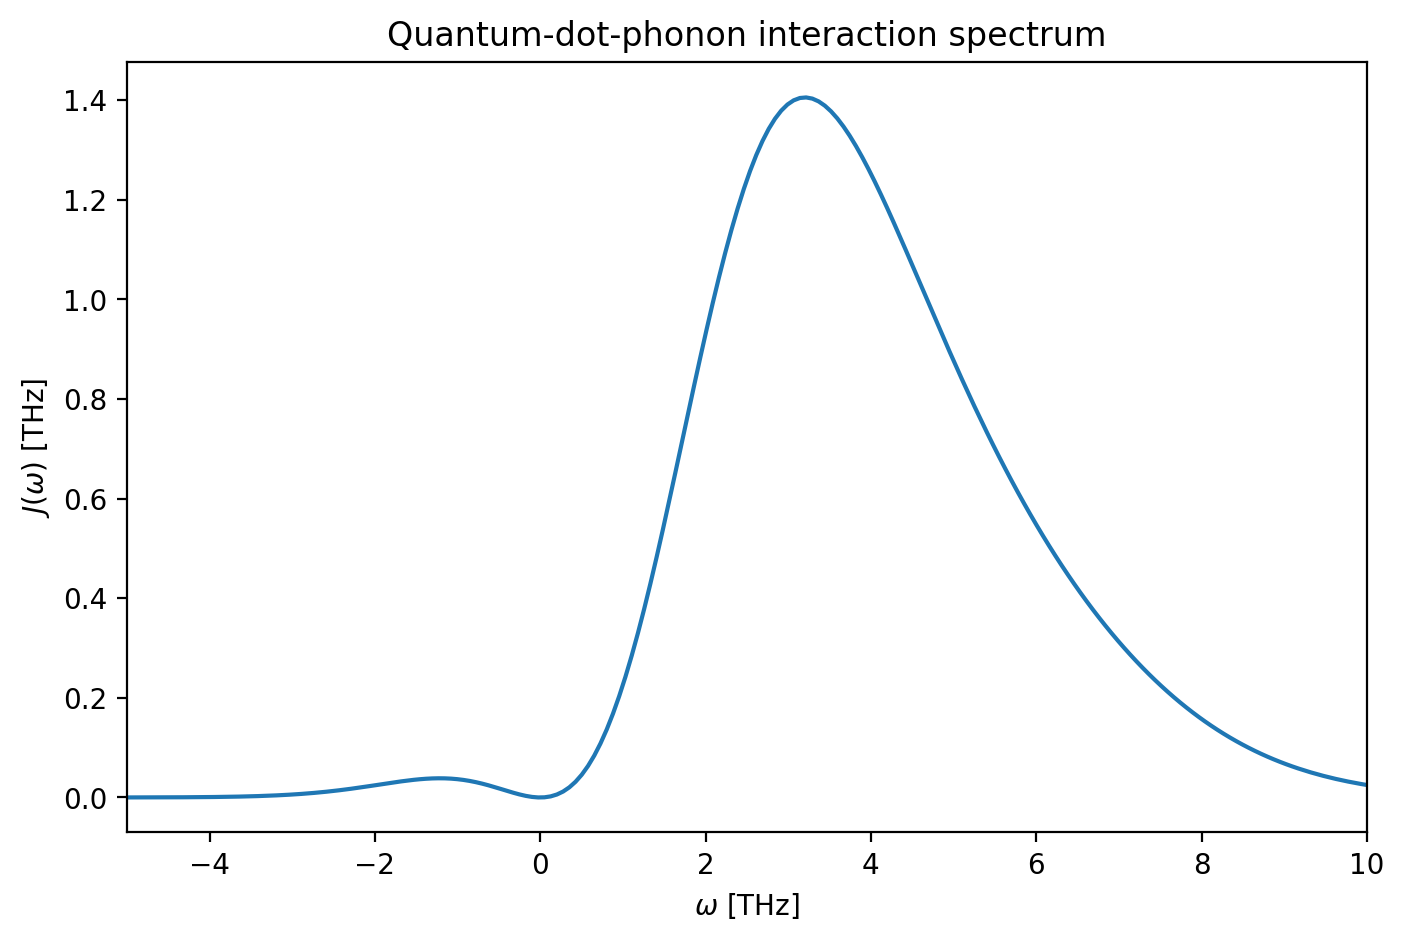

In [6]:
# frequency list
spec_list = np.linspace(-5, 10, 200)

# define shortcuts to evaluate string
pi = np.pi
exp = np.exp

# plot the spectrum J(w)
plt.figure(figsize=(8, 5))
plt.plot(spec_list, [eval(spectra_cb.replace("w", str(_))) for _ in spec_list])
plt.xlim(-5, 10)
plt.xlabel("$\\omega$ [THz]")
plt.ylabel("$J(\\omega)$ [THz]")
plt.title("Quantum-dot-phonon interaction spectrum");